In [1]:
from agentdesk import Desktop
from agentdesk.device import ProvisionConfig
from agentdesk.server.models import V1ProviderData

In [7]:
config = ProvisionConfig(provider=V1ProviderData(type="gce"))

In [9]:
desktop = Desktop.ensure("surfninja", config=config)

waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...

successfully created desktop 'surfninja'
starting proxy to vm...
proxy from local port 8000 to remote port 8000 started...
connected to desktop via agentd


In [3]:
desktop = Desktop.gce()

waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...
waiting for desktop to be ready...

successfully created desktop 'gracious-cray'
starting proxy to vm...
proxy from local port 8000 to remote port 8000 started...
connected to desktop via agentd


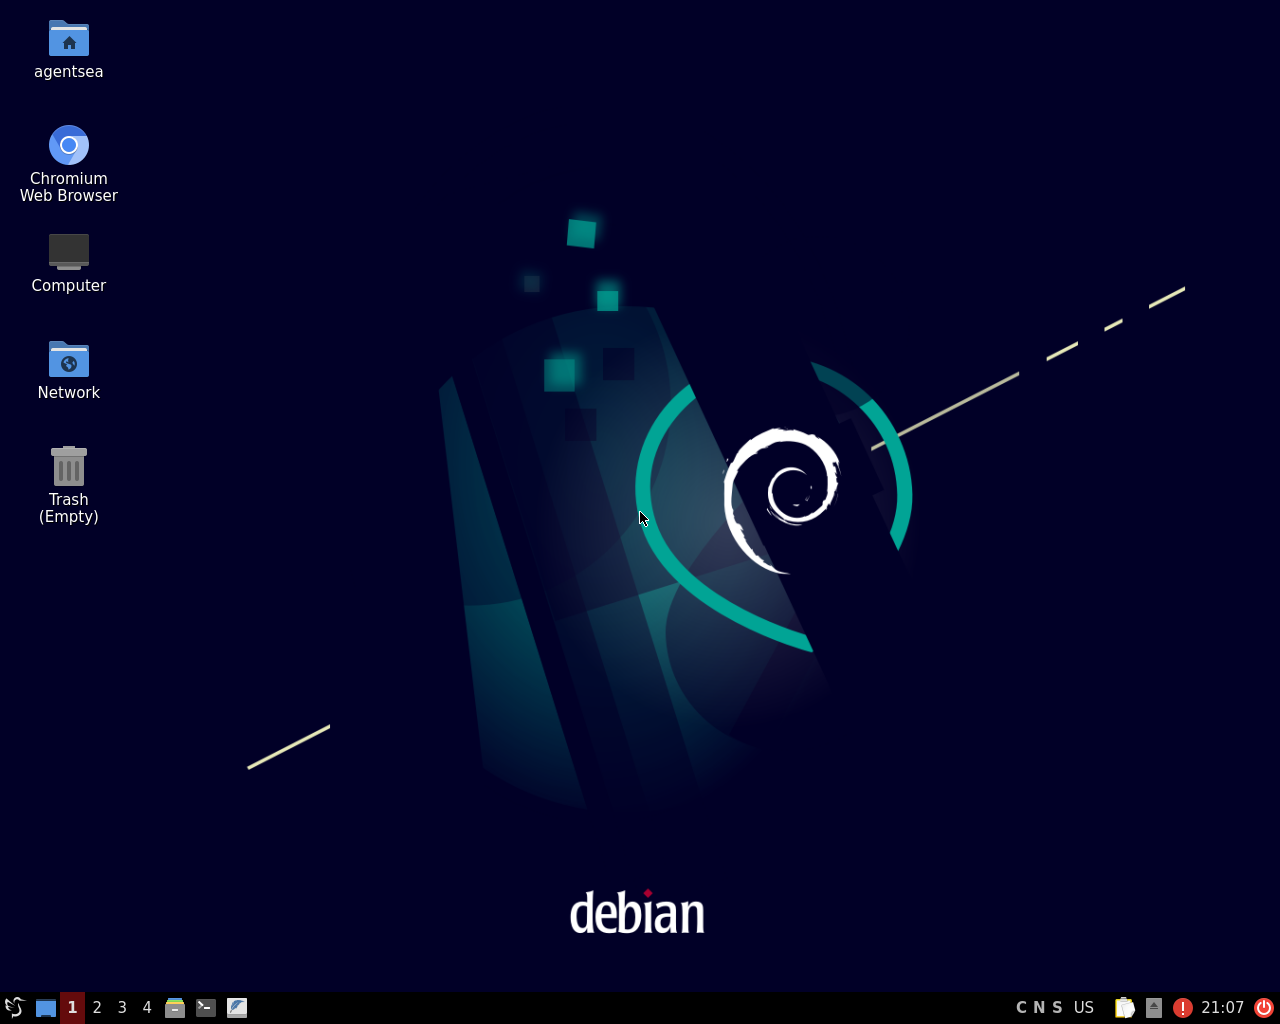

In [6]:
b64_to_image(desktop.take_screenshot())

In [7]:
desktop.info()

{'last_activity_ts': 1717189658,
 'screen_size': {'x': 1280, 'y': 1024},
 'os_info': 'Linux 6.5.0-1016-gcp',
 'code_version': 'fb21fa020ff6f3d3f5f81c2db5bffd66a82ea86c'}

In [8]:
desktop.mouse_coordinates()

(640, 512)

In [9]:
desktop.move_mouse(100, 100)

In [10]:
desktop.mouse_coordinates()

(100, 100)

# Describe Location

Describe the current location of the mouse

In [53]:
from pydantic import BaseModel, Field
from mllm import Router, RoleThread

router = Router.from_env()

class ClickArea(BaseModel):
    is_clickable: bool = Field(description="Whether the area is clickable")
    description: str = Field(description="Description of what the mouse cursor is over")
    location: str = Field(description="General location of the mouse cursor relative to the full screen, e.g. top left, bottom right")


2024-05-31 16:09:00,228 - mllm.router - INFO - loading models with preference: dict_keys(['gpt-4o', 'gpt-4-turbo', 'anthropic/claude-3-opus-20240229', 'gemini/gemini-pro-vision'])


2024-05-31 16:09:00,232 - mllm.router - INFO - Found LLM provider 'gpt-4o' API key in environment variables.
2024-05-31 16:09:00,232 - mllm.router - INFO - Found LLM provider 'gpt-4-turbo' API key in environment variables.
2024-05-31 16:09:00,233 - mllm.router - INFO - Found LLM provider 'anthropic/claude-3-opus-20240229' API key in environment variables.
2024-05-31 16:09:00,234 - mllm.router - INFO - Found LLM provider 'gemini/gemini-pro-vision' API key in environment variables.
Intialized router with Routing strategy: simple-shuffle

Routing fallbacks: [{'gpt-4o': ['gpt-4-turbo', 'anthropic/claude-3-opus-20240229', 'gemini/gemini-pro-vision']}, {'gpt-4-turbo': ['anthropic/claude-3-opus-20240229', 'gemini/gemini-pro-vision']}, {'anthropic/claude-3-opus-20240229': ['gemini/gemini-pro-vision']}]

Routing context window fallbacks: None

Router Redis Caching=None


In [12]:
from surfninja.img import b64_to_image, image_to_b64, crop_box_around

In [13]:
desktop.info()

{'last_activity_ts': 1717189676,
 'screen_size': {'x': 1280, 'y': 1024},
 'os_info': 'Linux 6.5.0-1016-gcp',
 'code_version': 'fb21fa020ff6f3d3f5f81c2db5bffd66a82ea86c'}

In [52]:
def describe_location(desktop: Desktop) -> ClickArea:
    thread = RoleThread()
    b64_img = desktop.take_screenshot()
    img = b64_to_image(b64_img)

    coords = desktop.mouse_coordinates()
    cropped = crop_box_around(img, coords[0], coords[1])

    thread.post(
        role="user",
        msg=f"""I'm going to provide you with two images. The first is a picture of a desktop UI, 
    the second is a cropped portion of the first image containing just a 100x100 portion focusing on where the mouse cursor is.
    Please describe what the mouse cursor as a JSON object conforming to the schema {ClickArea.model_json_schema()}.
    Please return just raw json. For example if you see the mouse above the chromium icon then 
    you would return {{"is_clickable": true, "description": "A blue chromium icon with the text 'chromium' beneath it", "location": "top-right"}}.
    """,
        images=[image_to_b64(img), image_to_b64(cropped)],
    )

    resp = router.chat(thread, expect=ClickArea)

    if not resp.parsed:
        raise ValueError("No click area found")

    return resp.parsed

# Identifying Targets

Identify all possible clickable targets on a screenshot

In [15]:
from typing import List

class Target(BaseModel):
    description: str = Field(description="A long description of the target e.g. A round blue button with the text 'login'")
    location: str = Field(description="A general location of the target e.g. top-right, center, bottom-left")
    purpose: str = Field(description="A general purpose of the target e.g. login, logout, register")

class Targets(BaseModel):
    targets: List[Target] = Field(description="A list of targets")

In [38]:
def get_targets(desktop: Desktop) -> Targets:
    thread = RoleThread()
    b64_img = desktop.take_screenshot()
    img = b64_to_image(b64_img)

    thread.post(
        role="user",
        msg=f"""I've provided you with an image of a desktop UI. Please describe all the possible targets that you can interact with.
    Please return a JSON object that conforms to the schema {Targets.model_json_schema()}.
    Please be exhaustive, describing all possibilities on the screenshot.
    Please return just raw json. For example {{"targets": [{{"description": "A green button resembling a user", "location": "top-left", "purpose": "open user settings"}}]}}
    """,
        images=[image_to_b64(img)]
    )
    resp = router.chat(thread, expect=Targets)

    if not resp.parsed:
        raise ValueError("No click area found")

    return resp.parsed

# Navigating to Targets
Navigate to a target description

In [17]:
class MoveDirection(BaseModel):
    x: int = Field(description="Amount to move in the x direction. Positive values move right, negative values move left. 1 is equal to 1 pixel.")
    y: int = Field(description="Amount to move in the y direction. Positive values move down, negative values move up. 1 is equal to 1 pixel.")

In [18]:
def get_move_direction(desktop: Desktop, target: Target) -> MoveDirection:
    thread = RoleThread()
    b64_img = desktop.take_screenshot()
    img = b64_to_image(b64_img)

    coords = desktop.mouse_coordinates()
    cropped = crop_box_around(img, coords[0], coords[1])


    thread.post(
        role="user",
        msg=f"""I've provided you with two images: a screenshot of a desktop UI, and a cropped 100x100 image of the current mouse location. 
    Your goal is to navigate to '{target.description}' located in '{target.location}'. The screen size is {img.size} and the current coordinates are {coords}. 
    Please tell me which direction to move the mouse to get there. Please return a JSON object which conforms to the schema {MoveDirection.model_json_schema()}.
    Please return raw json. For example, if I want to move 12 pixels to the left, and 3 pixels up, I would return: {{ "x": -12, "y": 3}}. You must move the mouse, 
    either 'x' or 'y' must be non-zero.
    """,
        images=[image_to_b64(img), image_to_b64(cropped)]
    )
    img.save("screenshot_move.png")
    cropped.save("cropped_move.png")
    resp = router.chat(thread, expect=MoveDirection)

    if not resp.parsed:
        raise ValueError("No click area found")

    return resp.parsed

In [19]:
from typing import Tuple
from PIL import Image

def apply_move(desktop: Desktop, direction: MoveDirection) -> Tuple[Image.Image, Image.Image]:
    current_coords = desktop.mouse_coordinates()
    print("current_cords: ", current_coords)

    # Calculate new absolute mouse coordinates
    new_x = current_coords[0] + direction.x
    new_y = current_coords[1] + direction.y

    print("new: ", new_x, new_y)

    # Move the mouse to the new coordinates
    desktop.move_mouse(x=new_x, y=new_y)

    b64_img = desktop.take_screenshot()
    img = b64_to_image(b64_img)

    coords = desktop.mouse_coordinates()
    cropped = crop_box_around(img, coords[0], coords[1])
    print("new_coords: ", coords)

    return img, cropped

In [34]:
class CursorType(BaseModel):
    type: str = Field(description="Can be 'default', 'text', or 'pointer'")


def det_cursor_type(desktop: Desktop) -> CursorType:
    thread = RoleThread()
    b64_img = desktop.take_screenshot()
    img = b64_to_image(b64_img)

    coords = desktop.mouse_coordinates()
    cropped = crop_box_around(img, coords[0], coords[1], padding=30)

    cropped.save("cursor.png")

    composite = Image.open("./cursor_composite_image.jpg")


    thread.post(
        role="user",
        msg=f"""I've provided you with two images; first is an image of a mouse cursor and the second is an image 
        displaying the different types of cursors and their names. Please return what type of cursor you see.
        Please return a json object which conforms to the schema {CursorType.model_json_schema()}.
        Please return just raw json. For example if the cursor looks like a standard pointer return {{"type": "default"}}
    """,
        images=[image_to_b64(cropped), image_to_b64(composite)]
    )
    resp = router.chat(thread, expect=CursorType)

    if not resp.parsed:
        raise ValueError("No click area found")

    return resp.parsed

class CheckGoal(BaseModel):
    done: bool = Field(description="Whether the cursor is over the correct location")
    
def is_finished(desktop: Desktop, target: Target) -> bool:
    
    thread = RoleThread()
    b64_img = desktop.take_screenshot()
    img = b64_to_image(b64_img)

    coords = desktop.mouse_coordinates()
    cropped = crop_box_around(img, coords[0], coords[1])


    thread.post(
        role="user",
        msg=f"""I've provided you with two images: a screenshot of a desktop UI, and a cropped 100x100 image of the current mouse location. 
    Your goal is to navigate to '{target.description}' located in '{target.location}'. The screen size is {img.size} and the current coordinates are {coords}. 
    Please tell me if we have achieved that goal. Please return your response as a JSON object which conforms to the schema {CheckGoal.model_json_schema()}.
    Please return raw json. If the goal is achieved the cursor should be directly over the target and should be a pointer, then return {{"done": true}}
    """,
        images=[image_to_b64(img), image_to_b64(cropped)]
    )
    resp = router.chat(thread, expect=CheckGoal)

    if not resp.parsed:
        raise ValueError("No click area found")

    return resp.parsed.done

# Agent

In [39]:
targets = get_targets(desktop)

2024-05-31 15:46:04,676 - mllm.router - DEBUG - llm response: {'id': 'chatcmpl-9V4MJ2CBXZtNLh2jianAevVVxiXfM', 'choices': [Choices(finish_reason='stop', index=0, message=Message(content='{\n  "targets": [\n    {\n      "description": "A round red circle with a white slash inside, located next to two arrow icons.",\n      "location": "top-left",\n      "purpose": "open Google homepage"\n    },\n    {\n      "description": "A lock icon in the address bar",\n      "location": "top-middle",\n      "purpose": "indicates secure connection"\n    },\n    {\n      "description": "A reload button that looks like a circular arrow",\n      "location": "top-left",\n      "purpose": "reload the webpage"\n    },\n    {\n      "description": "A star icon next to the address bar",\n      "location": "top-middle",\n      "purpose": "bookmark the page"\n    },\n    {\n      "description": "A dropdown menu with options for Gmail, Images, and other Google services",\n      "location": "top-right",\n      "

In [54]:
target = targets.targets[12]

In [55]:
target

Target(description="A grey button with 'I'm Feeling Lucky' text", location='center', purpose='take user to the top result of the search instantly')

In [35]:
desktop.open_url("https://google.com")

In [23]:
import logging
import sys
logger = logging.getLogger("mllm.router")
logger.setLevel(logging.DEBUG)

stdout_handler = logging.StreamHandler(sys.stdout)
stdout_handler.setLevel(logging.DEBUG)  # Ensuring the handler captures debug logs

# Optionally add a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stdout_handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(stdout_handler)

In [56]:
max_steps = 10

for step in range(max_steps):
    print("\n---- checking if task is finished...")
    cursor_type = det_cursor_type(desktop)

    print("cursor type: ", cursor_type.type)
    if cursor_type.type != "default":
        if is_finished(desktop, target):
            print("task is done")
            break

        print("task is not finished but cursor is not default")

        
    print("\n---- step: ", step)
    direct = get_move_direction(desktop, target)

    print("\n---- move direction: ", direct.model_dump())

    new_screen, new_cursor = apply_move(desktop, direct)
    new_screen.save("step_" + str(step) + ".png")


---- checking if task is finished...
2024-05-31 16:10:29,336 - mllm.router - DEBUG - llm response: {'id': 'chatcmpl-9V4k9OIyEMMjnud5oqY0HQxib9MNP', 'choices': [Choices(finish_reason='stop', index=0, message=Message(content='{"type": "pointer"}', role='assistant'))], 'created': 1717193429, 'model': 'gpt-4o-2024-05-13', 'object': 'chat.completion', 'system_fingerprint': 'fp_aa87380ac5', '_response_ms': 1364.368}
cursor type:  pointer
2024-05-31 16:10:31,659 - mllm.router - DEBUG - llm response: {'id': 'chatcmpl-9V4kBdD461ceP7K4rXJZ028ZVJMMs', 'choices': [Choices(finish_reason='stop', index=0, message=Message(content='{\n  "done": false\n}', role='assistant'))], 'created': 1717193431, 'model': 'gpt-4o-2024-05-13', 'object': 'chat.completion', 'system_fingerprint': 'fp_aa87380ac5', '_response_ms': 1934.521}
task is not finished but cursor is not default

---- step:  0
2024-05-31 16:10:36,458 - mllm.router - DEBUG - llm response: {'id': 'chatcmpl-9V4kD4AUQvYDicAjSCTV3FpKtRZYb', 'choices': 

KeyboardInterrupt: 